# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we introduce the $\ell_2$ regularization. So far, we see a gap between the training error and the test error, suggesting that the overfitting might be happening. Thus, using some regularization technique is worth trying.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:20<00:00,  4.76it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:44<00:00, 22.24it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:05<00:00,  7.21it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:19<00:00, 21.84it/s]


=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


## 2. Random Search
We choose different weight decay value, train the model for 10 epochs, and compare the test loss.

In [ ]:
epochs = 10
batch_size = 128
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

wd_pool = [0.0, 0.0001, 0.001, 0.01, 0.1]
train_losses, eval_losses = [], []

for weight_decay in wd_pool:
    print(f"\nWeight Decay = {weight_decay:.4f}")
    image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
    text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
    criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
    image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005, weight_decay=weight_decay)
    text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005, weight_decay=weight_decay)

    train_loss, eval_loss = [], []
    for epoch in range(epochs):
        trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
        train_loss.append(trainloss)
        evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
        eval_loss.append(evalloss)
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    wd_loss = {"train": train_losses, "test": eval_losses, "wd": wd_pool}
    with open(f"drive/My Drive/finalproj/wd_loss.pkl", "wb") as f:
        pickle.dump(wd_loss, f)


Weight Decay = 0.0000
   Epoch: 5 | Training loss: 0.0849 | Test loss: 0.1313
   Epoch: 10 | Training loss: 0.0693 | Test loss: 0.1258

Weight Decay = 0.0001
   Epoch: 5 | Training loss: 0.0794 | Test loss: 0.1258
   Epoch: 10 | Training loss: 0.0652 | Test loss: 0.1198

Weight Decay = 0.0010
   Epoch: 5 | Training loss: 0.0800 | Test loss: 0.1282
   Epoch: 10 | Training loss: 0.0658 | Test loss: 0.1233

Weight Decay = 0.0100
   Epoch: 5 | Training loss: 0.0994 | Test loss: 0.1387
   Epoch: 10 | Training loss: 0.0814 | Test loss: 0.1411

Weight Decay = 0.1000
   Epoch: 5 | Training loss: 0.1629 | Test loss: 0.1687
   Epoch: 10 | Training loss: 0.1599 | Test loss: 0.1675


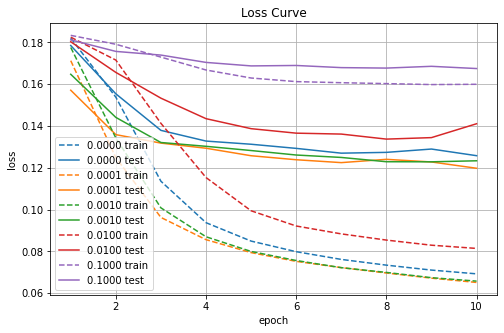

In [ ]:
plt.figure(figsize=(8,5))
for i in range(len(wd_pool)):
    plt.plot(np.arange(1, epochs + 1), train_losses[i], label=f"{wd_pool[i]:.4f} train", color=plt.cm.tab10(i), linestyle="dashed")
    plt.plot(np.arange(1, epochs + 1), eval_losses[i], label=f"{wd_pool[i]:.4f} test", color=plt.cm.tab10(i))
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

Another approach is to use Dropout.

In [ ]:
image_head_model = "FC_Dropout"
text_head_model = "FC_Dropout"

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,416

=== Text Encoder Head ===
  Trainable Parameters: 525,056


In [ ]:
epochs = 10
batch_size = 128
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_loss_dropout = []
eval_loss_dropout = []
for epoch in range(epochs):
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss_dropout.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss_dropout.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")

Epoch: 2 | Training loss: 0.1715 | Test loss: 0.1678
Epoch: 4 | Training loss: 0.1505 | Test loss: 0.1562
Epoch: 6 | Training loss: 0.1390 | Test loss: 0.1531
Epoch: 8 | Training loss: 0.1294 | Test loss: 0.1509
Epoch: 10 | Training loss: 0.1225 | Test loss: 0.1469


In [ ]:
with open(f"drive/My Drive/finalproj/wd_loss.pkl", "rb") as f:
    result = pickle.load(f)
    train_losses, eval_losses, wd_pool = result["train"], result["test"], result["wd"]

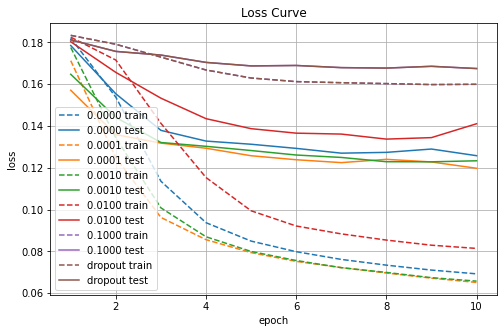

In [ ]:
plt.figure(figsize=(8,5))
for i in range(len(wd_pool)):
    plt.plot(np.arange(1, epochs + 1), train_losses[i], label=f"{wd_pool[i]:.4f} train", color=plt.cm.tab10(i), linestyle="dashed")
    plt.plot(np.arange(1, epochs + 1), eval_losses[i], label=f"{wd_pool[i]:.4f} test", color=plt.cm.tab10(i))
plt.plot(np.arange(1, epochs + 1), train_losses[i], label=f"dropout train", color=plt.cm.tab10(i + 1), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), eval_losses[i], label=f"dropout test", color=plt.cm.tab10(i + 1))
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.savefig("regularization.png", bbox_inches="tight")
plt.show()

## 3. Observation
From the plot above, we see using weight decay ranging 0.0001 to 0.001 can improve the model performance. However, we still have a huge gap between training and test loss, indicating more advanced regularization techniques are needed to be considered. Dropout with rate 0.35 couldn't beat the performance without a regularization.